In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
#from keras import ops
import tensorflow as tf

#import cv2|
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

2024-02-26 02:53:35.430783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 02:53:35.430908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 02:53:35.707677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using JAX backend.


## TRAIN, TEST AND VALIDATION DATA COLLECTION

In [2]:
import os
import pandas as pd

# Directory containing the images
train_dir = "/kaggle/input/fundus-pytorch/train"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["0", "1"]):
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(train_dir, subdir)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".png"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))

# Create a DataFrame from the list of file paths and labels
df_train = pd.DataFrame(data, columns=["file_path", "label"])

# Save the DataFrame to a CSV file
df_train.to_csv("train.csv", index=False)

#####################################################################################################
# Directory containing the images
test_dir = "/kaggle/input/fundus-pytorch/test"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["0", "1"]):
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(test_dir, subdir)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".png"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))

# Create a DataFrame from the list of file paths and labels
df_test = pd.DataFrame(data, columns=["file_path", "label"])

# Save the DataFrame to a CSV file
df_test.to_csv("test.csv", index=False)
##########################################################################################

# Directory containing the images
valid_dir = "/kaggle/input/fundus-pytorch/val"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["0", "1"]):
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(valid_dir, subdir)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".png"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))

# Create a DataFrame from the list of file paths and labels
df_valid = pd.DataFrame(data, columns=["file_path", "label"])

# Save the DataFrame to a CSV file
df_valid.to_csv("valid.csv", index=False)


## REGION OF INTEREST EXTRACTION

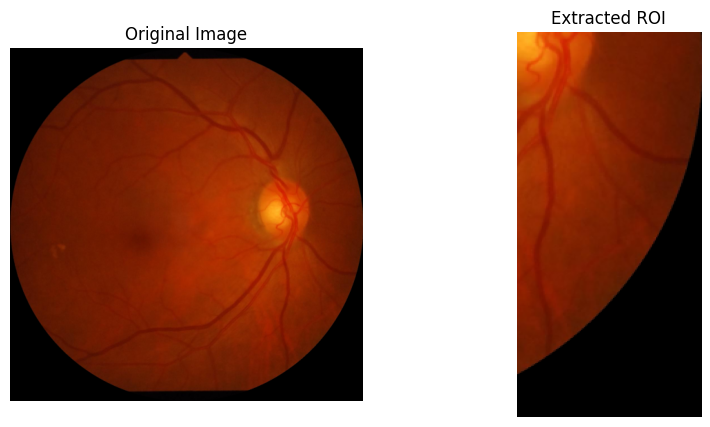

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = df_train["file_path"].sample().values[0]
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)

# Find the pixel with the highest intensity value
max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)

# Define the radius for the circle
radius = 6 // 2

# Get the x and y coordinates for cropping the image
x = max_intensity_pixel[1] - radius
y = max_intensity_pixel[0] - radius

# Crop the image
roi_image = image[y:y+512, x:x+512]

# Plot the original image and the extracted ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
plt.title('Extracted ROI')
plt.axis('off')

plt.show()


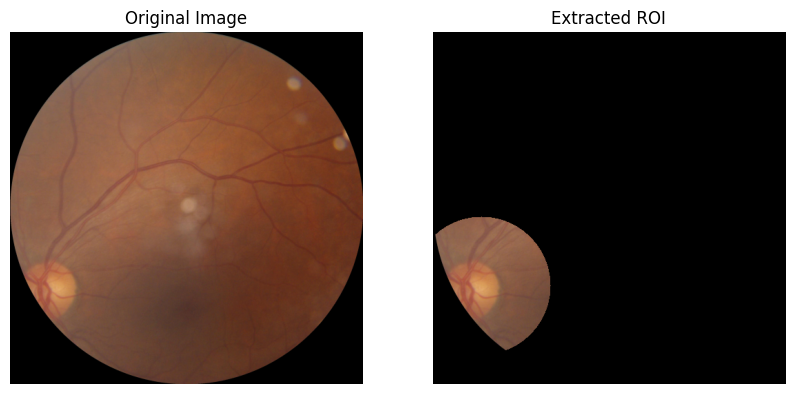

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = df_train["file_path"].sample().values[0]
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)

# Find the pixel with the highest intensity value
max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)

# Define the radius for the circle
radius = 200 // 2

# Get the x and y coordinates for cropping the image
x = max_intensity_pixel[1] - radius
y = max_intensity_pixel[0] - radius

# Create a mask for the circle
mask = np.zeros_like(image)
cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)

# Apply the mask to the original image
roi_image = cv2.bitwise_and(image, mask)

# Plot the original image and the extracted ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
plt.title('Extracted ROI')
plt.axis('off')

plt.show()



## PERFORM ROI ON THE DATA

In [5]:
import cv2
import numpy as np
import os
import pandas as pd

def extract_rois_and_labels(df, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize an empty list to store the rows of the DataFrame
    roi_rows = []
    
    for index, row in df.iterrows():
        # Load the image
        image = cv2.imread(row['file_path'])
        
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur
        blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)
        
        # Find the pixel with the highest intensity value
        max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)
        
        # Define the radius for the circle
        radius = 200 // 2
        
        # Get the x and y coordinates for cropping the image
        x = max_intensity_pixel[1] - radius
        y = max_intensity_pixel[0] - radius
        
        # Create a mask for the circle
        mask = np.zeros_like(image)
        cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)
        
        # Apply the mask to the original image
        roi_image = cv2.bitwise_and(image, mask)
        
        # Save the ROI image
        roi_filename = os.path.basename(row['file_path']).split('.')[0] + '_roi.jpg'
        roi_path = os.path.join(output_dir, roi_filename)
        cv2.imwrite(roi_path, roi_image)
        
        # Append the row to the list
        roi_rows.append({'roi_path': roi_path, 'label': row['label']})
    
    # Create a DataFrame from the list of rows
    roi_df = pd.DataFrame(roi_rows)
    
    return roi_df




###### PROCESSOR INTENSIVE CODE

In [6]:
# Extract ROIs and labels for the training images
train_roi_df = extract_rois_and_labels(df_train, 'train_roi_images')

# Extract ROIs and labels for the testing images
test_roi_df = extract_rois_and_labels(df_test, 'test_roi_images')

# Extract ROIs and labels for the validation images
valid_roi_df = extract_rois_and_labels(df_valid, 'valid_roi_images')

###### PLOT OF THE NEW DATAFRAMES

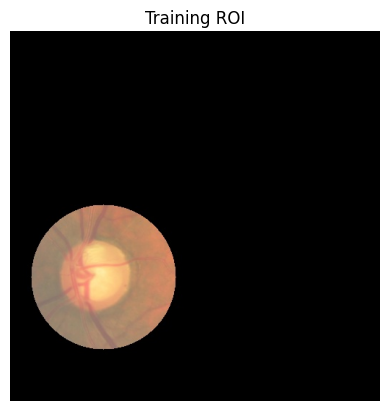

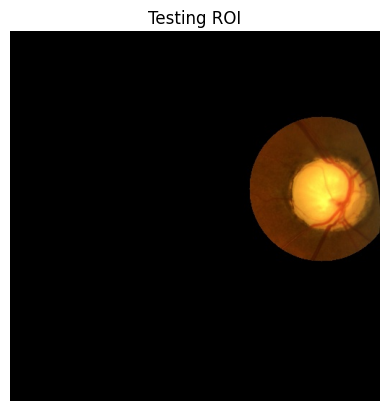

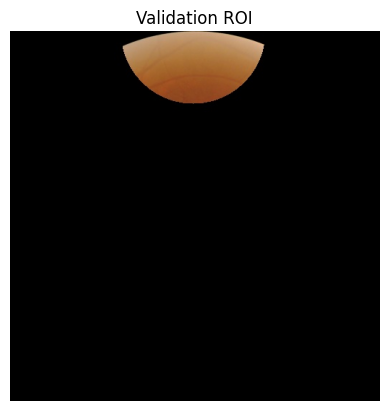

In [7]:
import matplotlib.pyplot as plt
import random

# Function to plot a random image from a DataFrame
def plot_random_image(df, title):
    # Get a random row from the DataFrame
    random_row = df.sample()
    
    # Load the image
    image_path = random_row['roi_path'].values[0]
    image = cv2.imread(image_path)
    
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot a random image from each DataFrame
plot_random_image(train_roi_df, 'Training ROI')
plot_random_image(test_roi_df, 'Testing ROI')
plot_random_image(valid_roi_df, 'Validation ROI')


In [8]:
train_roi_df.label.count()

8621

# DATA PREPROCESSING

In [9]:
# Convert the label column to strings
train_roi_df["label"] = train_roi_df["label"].astype(str)
test_roi_df["label"] = test_roi_df["label"].astype(str)
valid_roi_df["label"] = valid_roi_df["label"].astype(str)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generator for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define the data generator for validation images
valid_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create the training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_roi_df,
    x_col='roi_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Create the validation data generator
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_roi_df,
    x_col='roi_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
)

# Define the data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_roi_df,
    x_col='roi_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)


Found 8621 validated image filenames belonging to 2 classes.
Found 5747 validated image filenames belonging to 2 classes.
Found 2874 validated image filenames belonging to 2 classes.


## BUILDING U_NET ARCHITECTURE

In [11]:
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras.metrics import AUC

# def build_unet_model(input_shape):
#     inputs = tf.keras.Input(shape=input_shape)
    
#     # Encoder
#     conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
#     conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
#     # Bottleneck
#     conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
#     # Decoder
#     up4 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
#     merge4 = layers.concatenate([conv2, up4], axis=3)
#     conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge4)
#     conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
#     up5 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
#     merge5 = layers.concatenate([conv1, up5], axis=3)
#     conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge5)
#     conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
#     # Output
#     outputs = layers.Conv2D(1, 1, activation='softmax')(conv5)
    
#     model = tf.keras.Model(inputs=inputs, outputs=outputs, name="U-Net")
    
#     return model

# # Create the U-Net model
# unet_model = build_unet_model(input_shape=(256, 256, 3))

# # Compile the model with SGD optimizer
# sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# unet_model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=[AUC()],)

In [12]:
# unet_model.summary()

In [13]:
# tf.keras.utils.plot_model(unet_model, show_shapes=True)

### BUILDING NORMAL CNN ARCHITECTURE

In [14]:

import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
#     Dropout(0.5),  # Add dropout layer
    Dense(1, activation='sigmoid')
])
# NO DROPOUT LAYER FOR 0.83

sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, #LEARNING RATE TO 0.01 FOR 0.83
                                        momentum=0.9)
# unet_model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=[AUC()],)


# Compile the model
model.compile(optimizer=sgd_optimizer,
              loss='binary_crossentropy',
              metrics=[AUC()])

#CHANGE TO AUC FOR 0.83

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

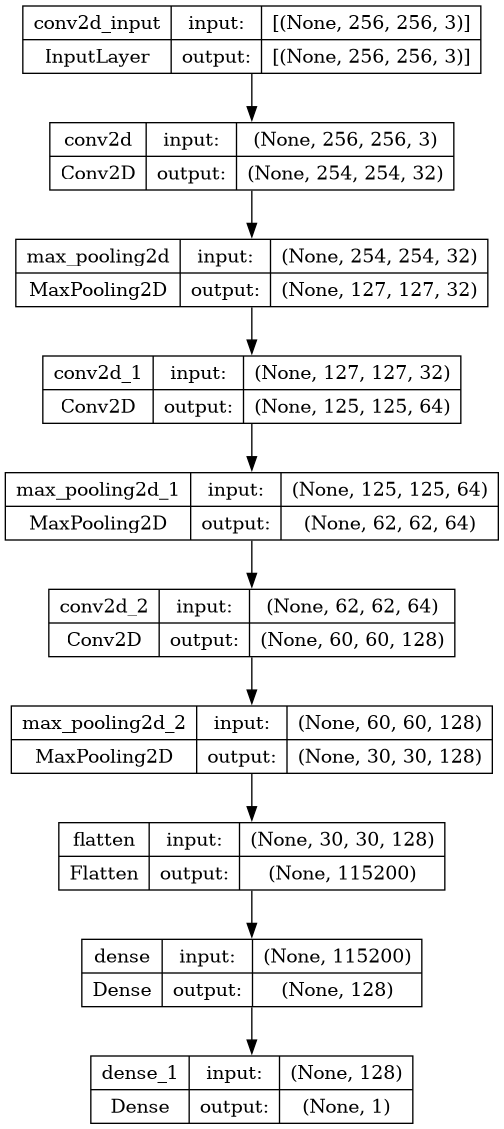

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

###### DEALING WITH CLASS IMBALANCE AND OVER FITTING

In [17]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)






In [18]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    shuffle=True,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/30


I0000 00:00:1708916619.199583      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


270/270 [==============================] - 44s 131ms/step - loss: 0.6458 - auc: 0.6276 - val_loss: 0.6342 - val_auc: 0.6811 - lr: 0.0100
Epoch 2/30
270/270 [==============================] - 33s 121ms/step - loss: 0.6244 - auc: 0.6738 - val_loss: 0.6278 - val_auc: 0.6778 - lr: 0.0100
Epoch 3/30
270/270 [==============================] - 42s 156ms/step - loss: 0.6069 - auc: 0.6993 - val_loss: 0.6154 - val_auc: 0.7139 - lr: 0.0100
Epoch 4/30
270/270 [==============================] - 33s 122ms/step - loss: 0.5839 - auc: 0.7257 - val_loss: 0.5553 - val_auc: 0.7650 - lr: 0.0100
Epoch 5/30
270/270 [==============================] - 32s 120ms/step - loss: 0.5612 - auc: 0.7525 - val_loss: 0.5777 - val_auc: 0.7574 - lr: 0.0100
Epoch 6/30
270/270 [==============================] - 35s 131ms/step - loss: 0.5588 - auc: 0.7561 - val_loss: 0.5455 - val_auc: 0.7780 - lr: 0.0100
Epoch 7/30
270/270 [==============================] - 33s 123ms/step - loss: 0.5400 - auc: 0.7798 - val_loss: 0.5295 - val_

# MODEL EVALUATION

In [19]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test accuracy: {test_acc}")

90/90 - 7s - loss: 0.3856 - auc: 0.8995 - 7s/epoch - 76ms/step
Test accuracy: 0.8994929790496826


In [20]:
import matplotlib.pyplot as plt

# Get the training and validation loss and AUC scores from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc_8']
val_auc = history.history['val_auc_8']

# Create a plot of the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Create a plot of the training and validation AUC scores
plt.subplot(1, 2, 2)
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.show()


KeyError: 'auc_8'

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)

# Convert the predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Glaucoma', 'Glaucoma'], yticklabels=['No Glaucoma', 'Glaucoma'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Calculate the area under the precision-recall curve (AUC)
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# SAVE MODEL

In [ ]:
model.save('GLAUCOMA_DETECTION.h5')